# Preparatory Processing and Calcs for the Heat Pump Calculator

In [23]:
import os
import csv
from datetime import datetime
import pickle

import pandas as pd
import numpy as np
from glob import glob
import requests
from IPython.display import display
from IPython.core.debugger import set_trace

# import matplotlib pyplot commands
from matplotlib.pyplot import *
 
# Show Plots in the Notebook
%matplotlib inline
 
rcParams['figure.figsize']= (10, 8)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

## Download TMY3 Files

In [3]:
TMY_FOLDER = r'C:\Users\Alan\Dropbox\TMY3'
TMY_URL = 'http://rredc.nrel.gov/solar/old_data/nsrdb/1991-2005/data/tmy3/{}TYA.CSV'
#for lin in open(os.path.join(TMY_FOLDER, 'tmy_list.txt')):
#    tmy_id = lin.strip().split()[0]
#    print('Processing: {}'.format(tmy_id))
#    resp = requests.get(TMY_URL.format(tmy_id))
#    open(os.path.join(TMY_FOLDER, '{}.csv'.format(tmy_id)), 'w').write(resp.text)


## Process TMY3 Files into Pickled DataFrames

In [17]:
# accumulates metadata for each TMY3 file
meta_list = []

for f in glob(os.path.join(TMY_FOLDER, '*.csv')):
    print('Processing: {}'.format(f))
    with open(f, newline='') as csvfile:
        
        # Use a csvreader just to process the header row
        tmyreader = csv.reader(csvfile)
        hdr = next(tmyreader)
        meta = dict(
            tmy_id = int(hdr[0]),
            city = hdr[1].strip(),
            state = hdr[2].strip(),
            utc_offset = float(hdr[3]),
            latitude = float(hdr[4]),
            longitude = float(hdr[5]),
            elevation = float(hdr[6]) * 3.28084   # in feet
        )
        
        # read the rest of the lines into a DataFrame
        df = pd.read_csv(csvfile)
        
        # start making final DataFrame
        df['db_temp'] = df['Dry-bulb (C)'] * 1.8 + 32.0   # deg F
        df['rh'] = df['RHum (%)']                         # 0 - 100
        df['wind_spd'] = df['Wspd (m/s)'] * 2.23694     # miles per hour
        df_final = df[['db_temp', 'rh', 'wind_spd']].copy()
        
        # make a list of date/times with the stamp occurring in the
        # middle of the hour associated with the data.  Also, use 
        # the year 2018 for all the timestamps
        ts = []
        for dt, tm in zip(df['Date (MM/DD/YYYY)'], df['Time (HH:MM)']):
            m, d, _ = dt.split('/')
            h, _ = tm.split(':')
            ts.append( datetime(2018, int(m), int(d), int(h) - 1, 30))
        
        df_final.index = ts
        df_final['month'] = df_final.index.month
        
        meta['db_temp_avg'] = df_final.db_temp.mean()
        meta['rh_avg'] = df_final.rh.mean()
        meta['wind_spd_avg'] = df_final.wind_spd.mean()
        meta_list.append(meta)
        
        # pickle it.
        df_final.to_pickle('data/climate/{}.pkl'.format(meta['tmy_id']))

df_meta = pd.DataFrame(meta_list)
df_meta.set_index('tmy_id', inplace=True)
df_meta.to_pickle('data/climate/tmy3_meta.pkl')

Processing: C:\Users\Alan\Dropbox\TMY3\700197.csv
Processing: C:\Users\Alan\Dropbox\TMY3\700260.csv
Processing: C:\Users\Alan\Dropbox\TMY3\700637.csv
Processing: C:\Users\Alan\Dropbox\TMY3\701043.csv
Processing: C:\Users\Alan\Dropbox\TMY3\701195.csv
Processing: C:\Users\Alan\Dropbox\TMY3\701330.csv
Processing: C:\Users\Alan\Dropbox\TMY3\701625.csv
Processing: C:\Users\Alan\Dropbox\TMY3\701718.csv
Processing: C:\Users\Alan\Dropbox\TMY3\701740.csv
Processing: C:\Users\Alan\Dropbox\TMY3\701780.csv
Processing: C:\Users\Alan\Dropbox\TMY3\701940.csv
Processing: C:\Users\Alan\Dropbox\TMY3\702000.csv
Processing: C:\Users\Alan\Dropbox\TMY3\702005.csv
Processing: C:\Users\Alan\Dropbox\TMY3\702035.csv
Processing: C:\Users\Alan\Dropbox\TMY3\702040.csv
Processing: C:\Users\Alan\Dropbox\TMY3\702070.csv
Processing: C:\Users\Alan\Dropbox\TMY3\702075.csv
Processing: C:\Users\Alan\Dropbox\TMY3\702084.csv
Processing: C:\Users\Alan\Dropbox\TMY3\702185.csv
Processing: C:\Users\Alan\Dropbox\TMY3\702186.csv


In [18]:
display(df_final.head())
display(df_final.tail())
df_meta

,db_temp,rh,wind_spd,month
2018-01-01 00:30:00,40.10,97,5.816044,1
2018-01-01 01:30:00,40.10,97,5.816044,1
2018-01-01 02:30:00,39.92,96,5.816044,1
2018-01-01 03:30:00,40.10,95,5.816044,1
2018-01-01 04:30:00,40.10,95,5.816044,1


,db_temp,rh,wind_spd,month
2018-12-31 19:30:00,28.40,65,11.408394,12
2018-12-31 20:30:00,27.68,66,9.842536,12
2018-12-31 21:30:00,27.14,65,8.500372,12
2018-12-31 22:30:00,26.60,65,6.934514,12
2018-12-31 23:30:00,26.42,62,10.289924,12


,city,db_temp_avg,elevation,latitude,longitude,rh_avg,state,utc_offset,wind_spd_avg
tmy_id,,,,,,,,,
700197,SELAWIK,24.855438,26.24672,66.600,-160.000,78.158676,AK,-9.0,9.655307
700260,BARROW W POST-W ROGERS ARPT [NSA - ARM],10.729712,32.80840,71.320,-156.620,84.193950,AK,-9.0,12.178734
700637,DEADHORSE,14.890158,75.45932,70.200,-148.483,81.881279,AK,-9.0,11.842146
701043,POINT HOPE (AWOS),24.074966,13.12336,68.350,-166.800,77.388927,AK,-9.0,15.689121
701195,SHISHMAREF (AWOS),25.309137,6.56168,66.267,-166.050,78.231279,AK,-9.0,13.223661
701330,KOTZEBUE RALPH WEIN MEMORIAL,23.303884,9.84252,66.883,-162.600,79.720662,AK,-9.0,12.160118
701625,ANAKTUVUK PASS,20.373089,2155.51188,68.133,-151.733,70.690982,AK,-9.0,8.641866
701718,AMBLER,26.395527,288.71392,67.100,-157.850,68.722717,AK,-9.0,6.285546
701740,BETTLES FIELD,24.438295,643.04464,66.917,-151.517,68.911872,AK,-9.0,6.881706


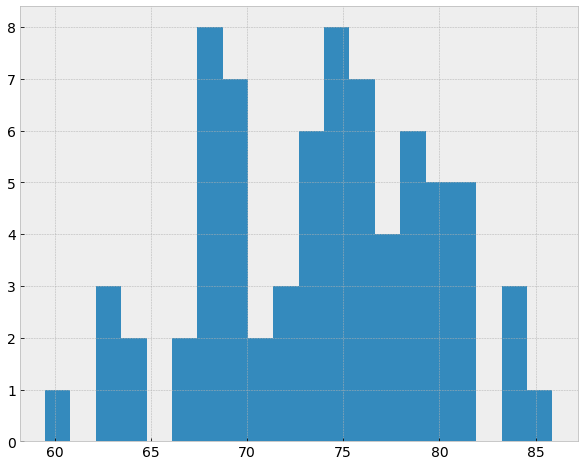

In [28]:
df_meta.rh_avg.hist(bins=20)

## Experiment with Haversine Distance Function

In [29]:
# Vectorized Haversine function to find distance between two points
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between a point on earth
    and an array of other points.  Lat/Lon in decimal degrees.
    lat1 & lon1 are the single point, lat2 and lon2 are numpy
    arrays.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2. * np.arcsin(np.sqrt(a))
    km = 6367. * c
    return km

In [30]:
df_tmy_meta = pd.read_pickle('data/climate/tmy3_meta.pkl')

In [31]:
dists = haversine(61.15, -149.850, df_tmy_meta.latitude, df_tmy_meta.longitude)
closest_site = dists.idxmin()
df_dist = df_tmy_meta.copy()
df_dist['dist'] = dists
df_dist.query('dist < 100')

,city,db_temp_avg,elevation,latitude,longitude,rh_avg,state,utc_offset,wind_spd_avg,dist
tmy_id,,,,,,,,,,
702590,KENAI MUNICIPAL AP,37.982904,85.30184,60.583,-151.233,76.492123,AK,-9.0,7.949589,97.813888
702595,SOLDOTNA,37.710377,111.54856,60.467,-151.033,71.117352,AK,-9.0,3.666513,99.352910
702730,ANCHORAGE INTL AP,37.330918,114.82940,61.183,-150.000,71.812100,AK,-9.0,7.130119,8.835709
702740,PALMER MUNICIPAL,41.468062,232.93964,61.600,-149.083,68.107648,AK,-9.0,7.371739,64.558871
702746,BIRCHWOOD,39.111397,98.42520,61.417,-149.517,69.378653,AK,-9.0,3.194330,34.589727
702757,WHITTIER,39.351295,29.52756,60.767,-148.683,78.169635,AK,-9.0,8.976386,75.989064


## Read in City and Utility Data and Process

In [52]:
# The Utility.csv had non-ASCII characters in it.  You can either read with 
# "engine='python' " in the 'read_csv()' command, or you can clean up the
# file with:  tr -cd '\11\12\15\40-\176' < file-with-binary-chars > clean-file
# I did both.
# The problem with Line 467 in the Utility.csv file in the Notes field.  That
# field started with a non-ASCII character.

df_city = pd.read_csv('data/City.csv', engine='python')
display(df_city.iloc[0])
df_city_util_link = pd.read_csv('data/City_Utility_Links.csv', engine='python')
display(df_city_util_link.head())
# had to use python engine to avoid error
df_util = pd.read_csv('data/Utility.csv', engine='python') 
df_util.ID = df_util.ID.astype(int)
df_util.drop(['SiteSourceMultiplierOverride', 'BuybackRate', 'Notes'], axis=1, inplace=True)
df_util.index = df_util.ID
df_util['NameShort'] = df_util['Name'].str[:6]
df_util.iloc[0]

ID                                                                   1
Name                                                         Anchorage
Active                                                               1
Latitude                                                         61.15
Longitude                                                      -149.86
FuelOnly                                                             0
IsSpecialHydro                                                       0
ERHRegionID                                                          2
WAPRegionID                                                          2
ImpCost                                                              1
OrigImpCost                                                          1
WeatherID                                                            2
WindMult                                                          0.91
SolarMult                                                            1
Elevat

,CityID,UtilityID
0,1,1
1,1,2
2,1,5
3,1,293
4,1,361


ID                                                1
Name                  Chugach Electric- Residential
Active                                            1
Type                                              1
IsCommercial                                      0
ChargesRCC                                        1
FuelSurcharge                                  0.06
PurchasedEnergyAdj                          0.00623
PCE                                               0
CO2                                             1.1
CustomerChg                                       8
DemandCharge                                    NaN
Block1                                          NaN
Block2                                          NaN
Block3                                          NaN
Block4                                          NaN
Block5                                          NaN
Rate1                                          0.11
Rate2                                           NaN
Rate3       

In [53]:
df_city = df_city.query('Active == 1')[[
    'ID',
    'Name',
    'Latitude',
    'Longitude',
    'FuelRefer',
    'FuelCityID',
    'Oil1Price',
    'Oil2Price',
    'PropanePrice',
    'BirchPrice',
    'SprucePrice',
    'CoalPrice',
    'SteamPrice',
    'HotWaterPrice',
    'MunicipalSalesTax',
    'BoroughSalesTax'
]]
df_city.set_index('ID', inplace=True)
df_city.head()

,Name,Latitude,Longitude,FuelRefer,FuelCityID,Oil1Price,Oil2Price,PropanePrice,BirchPrice,SprucePrice,CoalPrice,SteamPrice,HotWaterPrice,MunicipalSalesTax,BoroughSalesTax
ID,,,,,,,,,,,,,,,
1,Anchorage,61.15,-149.86,0,NaN,3.07,NaN,4.50,325.0,345.0,175.0,NaN,NaN,NaN,NaN
2,Adak,51.84,-176.63,0,NaN,4.42,4.69,NaN,NaN,NaN,NaN,NaN,NaN,0.04,NaN
3,Akutan,54.13,-165.77,0,NaN,2.45,2.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Allakaket,66.56,-152.64,0,NaN,7.00,NaN,11.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Angoon,57.49,-134.57,0,NaN,3.83,3.83,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN


In [54]:
def closest_tmy(city_ser, dft):
    """Finds the closest TMY3 site, and returns ID and City, State name of
    that TMY3 site.  'city_ser' is a Pandas Series describing the city, and 'dft'
    is a DataFrame of meta data describing the possible TMY sites. 
    """
    dists = haversine(city_ser.Latitude, city_ser.Longitude, dft.latitude, dft.longitude)
    closest_id = dists.idxmin()
    tmy_site = dft.loc[closest_id]
    return closest_site, '{}, {}'.format(tmy_site.city, tmy_site.state)


In [55]:
def nan_to_zero(val):
    """If val is NaN, returns 0.0 otherwise return val.
    """
    return 0.0 if np.isnan(val) else val

tmy_ids = []
tmy_names = []
utils = []
gas_prices = []
SELF_GEN_ID = 131   # ID number of "Self-Generation" utility
for ix, city_ser in df_city.iterrows():
    
    # get closest TMY3 site
    id, nm = closest_tmy(city_ser, df_tmy_meta)    
    tmy_ids.append(id)
    tmy_names.append(nm)
    
    # find electric utilities associated with city
    util_list = df_city_util_link.query('CityID == @ix')['UtilityID']
    df_city_utils = df_util.loc[util_list]
    elec_utils = df_city_utils.query('Type==1 and Active==1').copy()
    elec_utils.sort_values(by=['NameShort', 'IsCommercial', 'ID'], inplace=True)
    if len(elec_utils) > 0:
        utils.append(list(elec_utils.ID))
    else:
        utils.append([SELF_GEN_ID])
        
    # if there is a gas utility, set a gas price.
    gas_price = np.nan
    gas_utils = df_city_utils.query('Type==2 and Active==1').copy()
    # Use a residential gas utility, the smallest ID
    if len(gas_utils):
        gas_util = gas_utils.sort_values(by=['IsCommercial', 'ID']).iloc[0]
        # get the rate for a usage of 130 ccf
        for block in range(1, 6):
            block_val = gas_util['Block{}'.format(block)]
            #set_trace()
            if np.isnan(block_val) or block_val >= 130:
                gas_price = gas_util['Rate{}'.format(block)] + \
                            nan_to_zero(gas_util.FuelSurcharge) + \
                            nan_to_zero(gas_util.PurchasedEnergyAdj)
                break

    gas_prices.append(gas_price)
    
df_city['TMYid'] = tmy_ids
df_city['TMYname'] = tmy_names
df_city['ElecUtilities'] = utils
df_city['GasPrice'] =  gas_prices
df_city.head()

,Name,Latitude,Longitude,FuelRefer,FuelCityID,Oil1Price,Oil2Price,PropanePrice,BirchPrice,SprucePrice,CoalPrice,SteamPrice,HotWaterPrice,MunicipalSalesTax,BoroughSalesTax,TMYid,TMYname,ElecUtilities,GasPrice
ID,,,,,,,,,,,,,,,,,,,
1,Anchorage,61.15,-149.86,0,NaN,3.07,NaN,4.50,325.0,345.0,175.0,NaN,NaN,NaN,NaN,702725,"LAKE HOOD SEAPLANE, AK","[2, 293, 480, 1, 361, 548]",0.97
2,Adak,51.84,-176.63,0,NaN,4.42,4.69,NaN,NaN,NaN,NaN,NaN,NaN,0.04,NaN,702725,"ADAK NAS, AK","[677, 678]",NaN
3,Akutan,54.13,-165.77,0,NaN,2.45,2.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,702725,"DUTCH HARBOR, AK","[9, 288, 475]",NaN
4,Allakaket,66.56,-152.64,0,NaN,7.00,NaN,11.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,702725,"BETTLES FIELD, AK","[249, 291, 478]",NaN
5,Angoon,57.49,-134.57,0,NaN,3.83,3.83,NaN,NaN,NaN,NaN,NaN,NaN,0.03,NaN,702725,"SITKA JAPONSKI AP, AK","[283, 393, 580]",NaN


In [64]:
df_city.iloc[0]

Name                                  Anchorage
Latitude                                  61.15
Longitude                               -149.86
FuelRefer                                     0
FuelCityID                                  NaN
Oil1Price                                  3.07
Oil2Price                                   NaN
PropanePrice                                4.5
BirchPrice                                  325
SprucePrice                                 345
CoalPrice                                   175
SteamPrice                                  NaN
HotWaterPrice                               NaN
MunicipalSalesTax                           NaN
BoroughSalesTax                             NaN
TMYid                                    702725
TMYname                  LAKE HOOD SEAPLANE, AK
ElecUtilities        [2, 293, 480, 1, 361, 548]
GasPrice                                   0.97
Name: 1, dtype: object

In [56]:
df_city.query('GasPrice >= 0')[['Name', 'GasPrice']]

,Name,GasPrice
ID,,
1,Anchorage,0.97
12,Barrow/Utqiavik,0.32
16,Big Lake,0.97
36,Cooper Landing,0.97
41,Nuiqsut,0.00
244,Whittier,0.97
248,Anchor Point,0.97
249,Clam Gulch,0.97
257,Homer,0.97


In [67]:
df_city.query('FuelRefer > 0')

,Name,Latitude,Longitude,FuelRefer,FuelCityID,Oil1Price,Oil2Price,PropanePrice,BirchPrice,SprucePrice,CoalPrice,SteamPrice,HotWaterPrice,MunicipalSalesTax,BoroughSalesTax,TMYid,TMYname,ElecUtilities,GasPrice
ID,,,,,,,,,,,,,,,,,,,
240,Eyak,60.56,-145.7,1,38.0,2.76,NaN,3.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,702725,"CORDOVA, AK","[37, 366, 553]",NaN
322,Faribanks - Chena Ridge,64.80,-148.0,1,293.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,702725,"FAIRBANKS INTL ARPT, AK","[3, 380, 567, 683, 684]",2.08


In [72]:
# Also have to look to see if a city relies on another city
# for its fuel prices
for ix, cty in df_city.query('FuelRefer > 0').iterrows():
    # get the city referred to
    cty_fuel = df_city.loc[int(cty.FuelCityID)]
    # Transfer over fuel prices
    for c in df_city.columns:
        if c.endswith('Price'):
            df_city.loc[ix, c] = cty_fuel[c]
    print(df_city.loc[ix])
    print(df_city.loc[int(cty.FuelCityID)])

Name                           Eyak
Latitude                      60.56
Longitude                    -145.7
FuelRefer                         1
FuelCityID                       38
Oil1Price                      3.01
Oil2Price                       NaN
PropanePrice                      4
BirchPrice                      NaN
SprucePrice                     NaN
CoalPrice                       NaN
SteamPrice                      NaN
HotWaterPrice                   NaN
MunicipalSalesTax               NaN
BoroughSalesTax                 NaN
TMYid                        702725
TMYname                 CORDOVA, AK
ElecUtilities        [37, 366, 553]
GasPrice                        NaN
Name: 240, dtype: object
Name                        Cordova
Latitude                      60.54
Longitude                   -145.73
FuelRefer                         0
FuelCityID                      NaN
Oil1Price                      3.01
Oil2Price                       NaN
PropanePrice                      4
Bir

In [63]:
misc_info = pd.read_csv('data/Misc_Info.csv', engine='python').iloc[0]
misc_info

ID                                                                      1
LibVersion                                              2/27/2018 0:00:00
DiscountRate                                                         0.03
RegSurcharge                                                       0.0032
RegSurchargeElectric                                               0.0009
PCEkWhLimit                                                           500
PCEFundingPct                                                           1
MiscNotes               Inflation factors and discount rate from 2011 ...
Name: 0, dtype: object

In [34]:
df_fuel = pd.read_excel('data/Fuel.xlsx', index_col='id')
df_fuel['btus'] = df_fuel.btus.astype(float)
df_fuel

,desc,unit,btus,co2,price_col
id,,,,,
1,Natural Gas,ccf,103700.0,117.0,GasPrice
2,Propane,gallon,91333.0,139.0,PropanePrice
3,#1 Oil,gallon,137452.0,161.3,Oil1Price
4,#2 Oil,gallon,138500.0,161.3,Oil2Price
5,Birch Wood,cord,26200000.0,0.0,BirchPrice
6,Spruce Wood,cord,18100000.0,0.0,SprucePrice
7,Coal,ton,15100000.0,214.3,CoalPrice
8,"District Heat, Steam",thousand pounds,960000.0,58.0,SteamPrice
9,"District Heat, Hot Water",million BTU,1000000.0,58.0,HotWaterPrice


In [35]:
df_fuel.iloc[0]

desc         Natural Gas
unit                 ccf
btus              103700
co2                  117
price_col       GasPrice
Name: 1, dtype: object